# Stock Market Analysis Story: VOO, QQQM, NVDA, ONDS

## 1. Introduction

This notebook analyzes one year of market behavior across four different instruments:
- **VOO**: Broad S&P 500 exposure
- **QQQM**: Nasdaq-100 growth exposure
- **NVDA**: Large-cap technology stock
- **ONDS**: Smaller-cap technology stock

The objective is to compare performance, volatility, and diversification patterns using a consistent analysis pipeline.

We will move from raw data collection to practical insights using visual and statistical summaries.

## 2. Data Collection

We fetch one year of historical OHLCV data using the reusable module in `src/data_fetcher.py`.

The dataset returned by `get_stock_data` uses a multi-index column format: `(field, ticker)` where field includes values such as `Open`, `High`, `Low`, `Close`, `Adj Close`, and `Volume`.

In [3]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Resolve project root whether notebook is launched from repo root or notebooks/
cwd = Path.cwd().resolve()
PROJECT_ROOT = cwd.parent if cwd.name == "notebooks" else cwd
if not (PROJECT_ROOT / "src").exists():
    PROJECT_ROOT = cwd.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.data_fetcher import get_stock_data

# Plot style
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (12, 6)

# Fetch 1 year of data
tickers = ["VOO", "QQQM", "NVDA", "ONDS"]
stock_df = get_stock_data(tickers=tickers, period="1y")

stock_df.head()

Price        Adj Close                                     Close        \
Ticker            NVDA  ONDS        QQQM         VOO        NVDA  ONDS   
Date                                                                     
2025-02-18  139.361893  1.65  220.858170  555.477417  139.399994  1.65   
2025-02-19  139.191925  1.43  220.868118  556.820862  139.229996  1.43   
2025-02-20  140.071686  1.39  219.953217  554.479675  140.110001  1.39   
2025-02-21  134.393234  1.25  215.408569  545.045654  134.429993  1.25   
2025-02-24  130.244385  1.10  212.852814  542.467468  130.279999  1.10   

Price                                     High        ...         Low  \
Ticker            QQQM         VOO        NVDA  ONDS  ...        QQQM   
Date                                                  ...               
2025-02-18  222.089996  562.309998  143.440002  1.94  ...  220.699997   
2025-02-19  222.100006  563.669983  141.360001  1.68  ...  220.880005   
2025-02-20  221.179993  561.299988  140.660004  1.46  ...  219.244995   
2025-02-21  216.610001  551.750000  141.460007  1.45  ...  216.449997   
2025-02-24  214.039993  549.140015  138.589996  1.26  ...  213.889999   

Price                         Open                                    Volume  \
Ticker             VOO        NVDA   ONDS        QQQM         VOO       NVDA   
Date                                                                           
2025-02-18  559.489990  141.270004  1.835  222.220001  561.799988  219176600   
2025-02-19  560.530029  139.509995  1.640  221.759995  561.020020  167536000   
2025-02-20  558.219971  140.029999  1.390  221.789993  562.390015  143903600   
2025-02-21  551.270020  140.039993  1.400  221.630005  561.099976  228217600   
2025-02-24  548.510010  136.559998  1.250  217.330002  553.609985  251381100   

Price                                  
Ticker         ONDS     QQQM      VOO  
Date                                   
2025-02-18  3484500  1868400  3844900  
2025-02-19  5038100  1409600  3857600  
2025-02-20  2375800  1561200  4446800  
2025-02-21  2586600  2301200  6148700  
2025-02-24  3109900  2555400  4772300  

[5 rows x 24 columns]

In [4]:
print("Shape:", stock_df.shape)
print("Date range:", stock_df.index.min().date(), "to", stock_df.index.max().date())

close_prices = stock_df["Adj Close"] if "Adj Close" in stock_df.columns.get_level_values(0) else stock_df["Close"]
close_prices.describe().T

Shape: (251, 24)
Date range: 2025-02-18 to 2026-02-17


,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
NVDA,251.0,160.250154,30.178046,94.292885,134.955505,175.020004,183.350006,207.028473
ONDS,251.0,4.915449,3.925481,0.677000,1.090000,3.860000,7.985000,14.010000
QQQM,251.0,230.301184,23.379008,170.723511,213.110550,234.224548,251.055473,261.457245
VOO,251.0,577.198509,47.968497,452.754395,539.938507,587.353271,620.947693,639.700012


## 3. Price Trends

Raw prices are not directly comparable because each asset starts at a different level.

To compare relative performance fairly, we normalize all series to start at **100** on the first day.

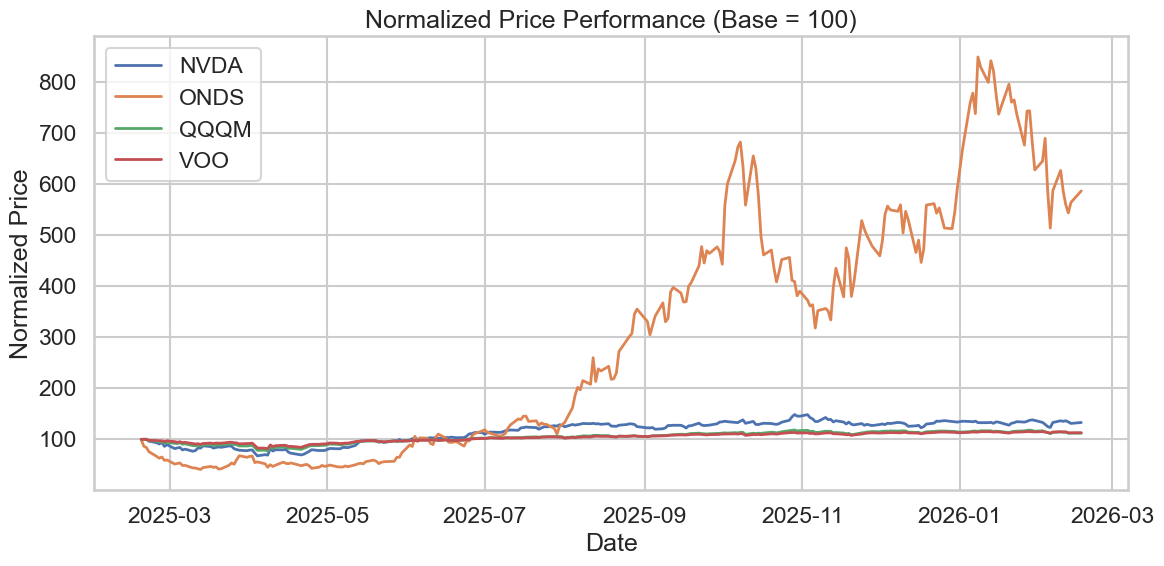

In [6]:
normalized_prices = close_prices / close_prices.iloc[0] * 100

fig, ax = plt.subplots()
for ticker in normalized_prices.columns:
    ax.plot(normalized_prices.index, normalized_prices[ticker], label=ticker, linewidth=2)

ax.set_title("Normalized Price Performance (Base = 100)")
ax.set_xlabel("Date")
ax.set_ylabel("Normalized Price")
ax.legend()
plt.tight_layout()
plt.show()

## 4. Returns Analysis

Daily returns provide a clearer view of short-term behavior and risk.

Below, each subplot shows the return distribution for one ticker, with annotations for:
- **Mean daily return**
- **Standard deviation** (a volatility proxy)

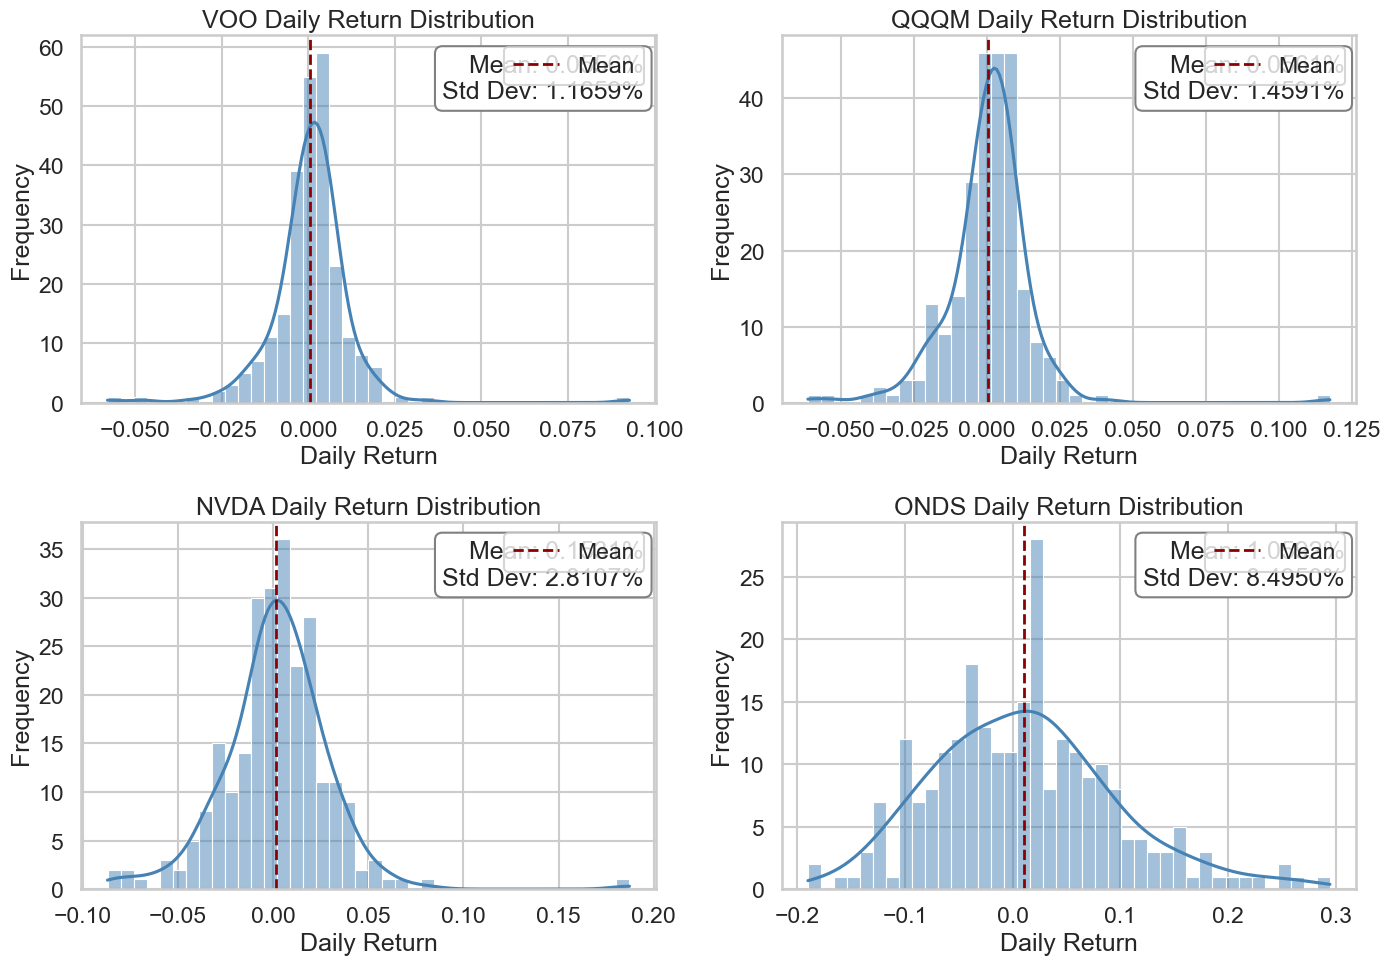

In [8]:
daily_returns = close_prices.pct_change().dropna()

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=False, sharey=False)
axes = axes.flatten()

for i, ticker in enumerate(tickers):
    ax = axes[i]
    series = daily_returns[ticker]
    mean_val = series.mean()
    std_val = series.std()

    sns.histplot(series, bins=40, kde=True, ax=ax, color="steelblue")
    ax.axvline(mean_val, color="darkred", linestyle="--", linewidth=2, label="Mean")
    ax.set_title(f"{ticker} Daily Return Distribution")
    ax.set_xlabel("Daily Return")
    ax.set_ylabel("Frequency")
    ax.legend()

    text = f"Mean: {mean_val:.4%}\nStd Dev: {std_val:.4%}"
    ax.text(
        0.98,
        0.95,
        text,
        transform=ax.transAxes,
        ha="right",
        va="top",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray"),
    )

plt.tight_layout()
plt.show()

## 5. Risk vs Return

A useful portfolio lens is to compare:
- **Annualized return** (reward)
- **Annualized volatility** (risk)

Each dot below represents one ticker.

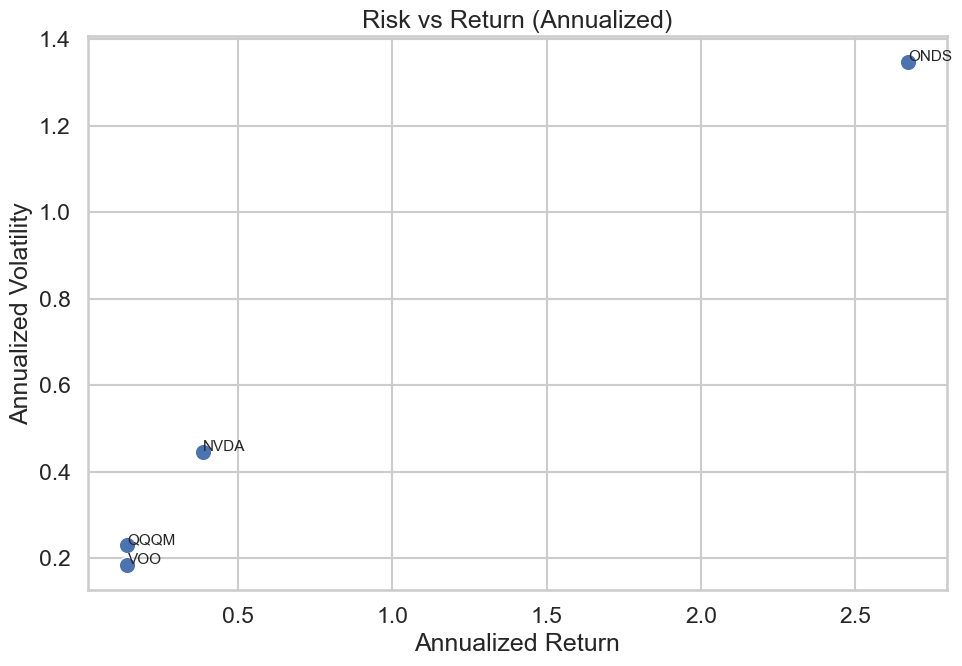

,Annualized Return,Annualized Volatility
Ticker,,
ONDS,2.669190,1.348537
NVDA,0.385753,0.446190
QQQM,0.141404,0.231631
VOO,0.140131,0.185086


In [10]:
annualized_return = daily_returns.mean() * 252
annualized_volatility = daily_returns.std() * np.sqrt(252)

risk_return_df = pd.DataFrame({
    "Annualized Return": annualized_return,
    "Annualized Volatility": annualized_volatility,
})

fig, ax = plt.subplots(figsize=(10, 7))

sns.scatterplot(
    data=risk_return_df,
    x="Annualized Return",
    y="Annualized Volatility",
    s=140,
    ax=ax,
)

for ticker, row in risk_return_df.iterrows():
    ax.text(
        row["Annualized Return"] + 0.002,
        row["Annualized Volatility"] + 0.002,
        ticker,
        fontsize=11,
    )

ax.set_title("Risk vs Return (Annualized)")
ax.set_xlabel("Annualized Return")
ax.set_ylabel("Annualized Volatility")
plt.tight_layout()
plt.show()

risk_return_df.sort_values("Annualized Return", ascending=False)

## 6. Correlation Heatmap

Correlation measures how similarly assets move day to day.

- Values near **1** indicate strong co-movement
- Values near **0** indicate weak linear relationship
- Lower correlation can support diversification

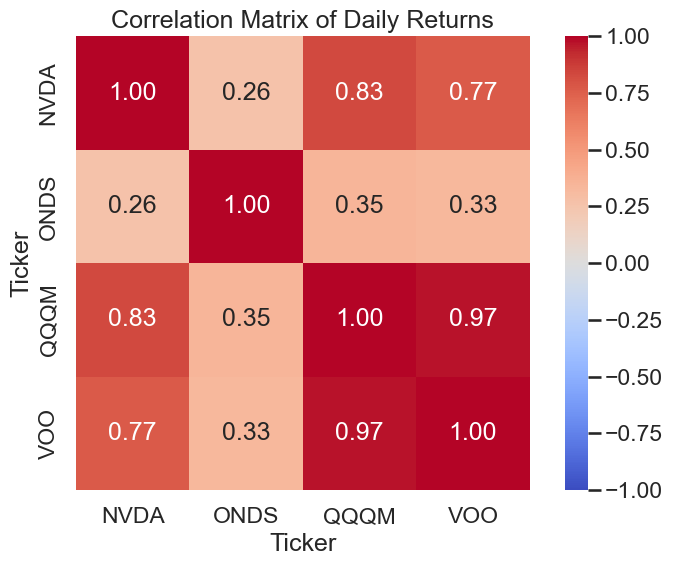

Ticker,NVDA,ONDS,QQQM,VOO
Ticker,,,,
NVDA,1.000000,0.264171,0.828815,0.770007
ONDS,0.264171,1.000000,0.346870,0.329231
QQQM,0.828815,0.346870,1.000000,0.973210
VOO,0.770007,0.329231,0.973210,1.000000


In [12]:
correlation_matrix = daily_returns.corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    ax=ax,
)
ax.set_title("Correlation Matrix of Daily Returns")
plt.tight_layout()
plt.show()

correlation_matrix

## 7. Moving Averages (NVDA)

Moving averages help smooth noisy price action and highlight trend direction.

Here we plot NVDA close price with:
- **20-day SMA** (short-term trend)
- **50-day SMA** (medium-term trend)

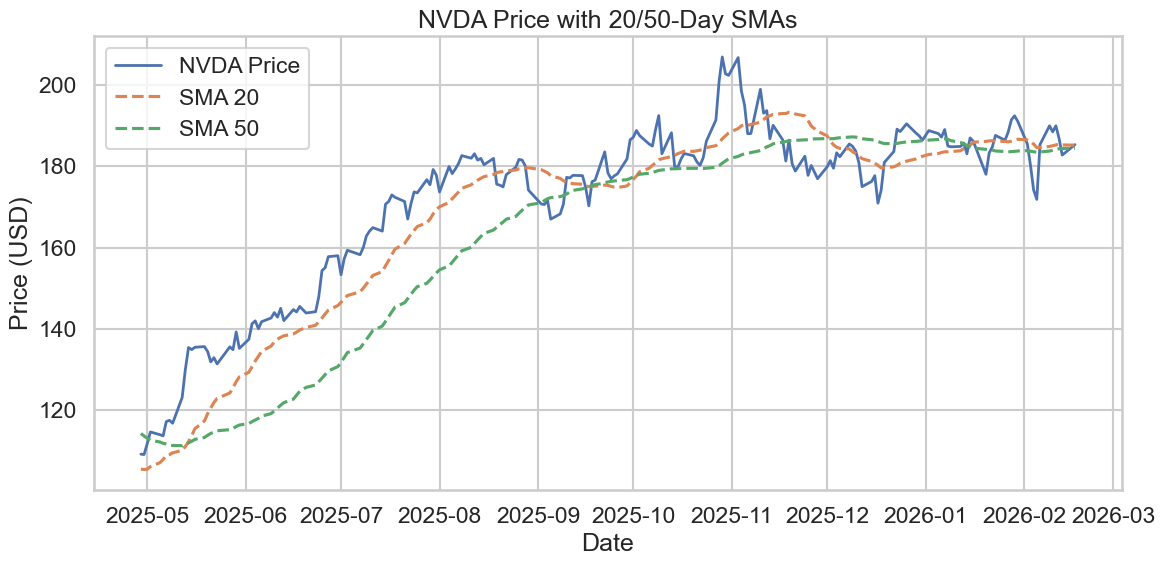

Price,Adj Close,SMA 20,SMA 50
Date,,,
2026-02-10,188.539993,185.114500,183.976001
2026-02-11,190.050003,185.326501,184.237198
2026-02-12,186.940002,185.516501,184.377799
2026-02-13,182.809998,185.304501,184.405001
2026-02-17,185.384995,185.262251,184.521100


In [14]:
nvda_df = stock_df.xs("NVDA", axis=1, level=1).copy()

price_col = "Adj Close" if "Adj Close" in nvda_df.columns else "Close"
nvda_df["SMA 20"] = nvda_df[price_col].rolling(window=20).mean()
nvda_df["SMA 50"] = nvda_df[price_col].rolling(window=50).mean()

plot_df = nvda_df.dropna(subset=["SMA 20", "SMA 50"]).copy()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(plot_df.index, plot_df[price_col], label="NVDA Price", linewidth=2)
ax.plot(plot_df.index, plot_df["SMA 20"], label="SMA 20", linestyle="--")
ax.plot(plot_df.index, plot_df["SMA 50"], label="SMA 50", linestyle="--")

ax.set_title("NVDA Price with 20/50-Day SMAs")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax.legend()
plt.tight_layout()
plt.show()

plot_df[[price_col, "SMA 20", "SMA 50"]].tail()

## 8. Key Findings

1. **Relative performance diverges meaningfully**: Normalized price paths show that concentrated tech exposure (NVDA) can materially outperform broad index funds in strong periods, but with larger swings.
2. **Risk scales with return potential**: In the risk-vs-return view, higher annualized return candidates also show higher annualized volatility, reinforcing the reward-risk tradeoff.
3. **Broad ETFs remain highly related**: VOO and QQQM are positively correlated, while single-stock behavior (especially ONDS/NVDA) can deviate more from ETF movement.
4. **Return distributions differ in dispersion**: Histograms indicate wider daily return spread for individual stocks than diversified ETFs, signaling higher day-to-day uncertainty.
5. **Trend filters add context**: NVDA's 20/50-day SMA overlay helps distinguish short-term momentum from medium-term trend direction and can improve interpretation of raw price moves.

This framework can be extended with additional tickers, longer periods, drawdown analysis, and portfolio-level optimization.